# Forewords

This notebook aims at showing the complete generation of the FINSURF "adjusted" model, from the cross-validation to the finale model full training.

It also includes examples of variants from the training set evaluated using the feature contribution method described in the paper.

Since these example variants are taken from the training dataset, we make use of the random sampling process that takes place in the trees, so that the feature contribution values are calculated only from the subset of trees which did not sample these variants during the training.

# Imports and definitions

## Imports

In [1]:
from IPython.display import display

import datetime
import functools
import gzip
import importlib
import itertools as itt
import random
import os
import pickle
import re
import sys
import time
import yaml

import scipy.stats

import tabix
import tempfile

import pandas as pd
import numpy as np

In [2]:
path = '../code_train/FINSURF_train/utils'
if not path in sys.path:
    sys.path.insert(0, path)

import dataframes
importlib.reload(dataframes)

import ML_tests
importlib.reload(ML_tests)

import ML_visualization
importlib.reload(ML_visualization)

<module 'ML_visualization' from '../code_train/FINSURF_train/utils/ML_visualization.py'>

In [3]:
path = '../code_train/FINSURF_train/models_scripts/'

if not path in sys.path:
    sys.path.insert(0, path)

from select_variants import read_indices, write_indices, memory_aware_loading, load_model_dataset

import finsurf_forest
import finsurf_treeinterpreter_nopool

import feature_contribs_lib
import create_model_lib

importlib.reload(feature_contribs_lib)
importlib.reload(finsurf_treeinterpreter_nopool)

import model_comparison_lib
importlib.reload(model_comparison_lib)

<module 'model_comparison_lib' from '../code_train/FINSURF_train/models_scripts/model_comparison_lib.py'>

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
husl = sns.color_palette('husl',32)
sns.palplot(husl)
plt.close()
plt.style.use('seaborn-notebook')

SMALL_SIZE=16
MEDIUM_SIZE=20
BIGGER_SIZE=22

mpl.rc('font',size=SMALL_SIZE)
mpl.rc('axes',titlesize=SMALL_SIZE)
mpl.rc('axes',labelsize=MEDIUM_SIZE)
mpl.rc('xtick',labelsize=SMALL_SIZE)
mpl.rc('ytick',labelsize=SMALL_SIZE)
mpl.rc('legend',fontsize=SMALL_SIZE)
mpl.rc('figure',titlesize=BIGGER_SIZE)

In [5]:
import pybedtools as pbt

BASEPATH_TMPDIR = "/localtmp/moyon/" # To be changed by the user.

if not os.path.exists(BASEPATH_TMPDIR):
    os.makedirs(BASEPATH_TMPDIR)

tmp_dir = tempfile.TemporaryDirectory(dir=BASEPATH_TMPDIR).name
os.makedirs(tmp_dir)
pbt.set_tempdir(tmp_dir)

print("Temporary BedTool files will be stored in '{}'".format(tmp_dir))

Temporary BedTool files will be stored in '/localtmp/moyon/tmpzwbuq352'


In [6]:
import sklearn_pandas
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.impute
from sklearn.externals import joblib

## Definitions

Here we overload some of the functions previously defined so to be able to load anonymized vaariants.

In [7]:
def local_load_KfoldResults(name, path):
    return create_model_lib.KfoldResults(name="FINSURF-Adjusted",
                                         path=path_dir)

In [8]:
def load_regulatory_regions():
    path = "../data/regulatory_regions/FINSURF_REGULATORY_REGIONS_GENES.bed.gz"
    tmp = pd.read_csv(path,
                      header=0,
                      index_col=None,
                      sep="\t",
                     )
    # Split by chromosome to make a dictionnary with chroms as keys and bedtools objects as values.
    
    bt_regions_finsurf = {}
    
    for chrom, sub_df in tmp.groupby('#chrom'):
        print(chrom)
        bt_regions = pbt.BedTool.from_dataframe(sub_df)
        bt_regions_finsurf[chrom] = bt_regions     
        
    return bt_regions_finsurf


# Initialization and data loading

## Metadata initialization

Here we initialize variables that are used for defining the kind of distributions for the annotations, as well as some visual parameters for plots (e.g. in which color to plot some feature).

In [9]:
colmetadata_fp = "../data/variants/numeric_variants_colMetadata.yaml"

colmetadata = yaml.load(open(colmetadata_fp,'r'))

col_types = {c:v['distype'] for c,v in colmetadata.items()
             if not v['distype']=='other'}

feature_colors = {c:v['color'] for c,v in colmetadata.items()}
feature_colors['vartrans.ord'] = '#30db88' # variant type annotation is assigned to "GENOME annotations"

In [10]:
example_dataset_train_table = '../data/trained_model/datasets/X.tsv.gz'
num_cols = [c for c in pd.read_table(example_dataset_train_table,nrows=3).columns
            if c in col_types.keys()]

In [11]:
# ADDING THE GENES-ANNOTATIONS COLUMNS
if not 'ratio_shared_targets' in num_cols:
    num_cols.append('ratio_shared_targets')
    
if not 'targets_associations' in num_cols:
    num_cols.append('ratio_shared_targets')
    
# This will be used to update the metadata dict associated to the original numeric table.
targets_associations_metadata = {
    'ratio_shared_targets':{
        'category':'ENHANCERS',
        'color':'#1260e8',
        'distype':'continuous',
        'old_name':'ratio_shared_targets'
    },
    'targets_associations':{
        'category':'ENHANCERS',
        'color':'#1260e8',
        'distype':'discrete',
        'old_name':'targets_associations'
    }
}

colmetadata.update(targets_associations_metadata)

In [12]:
# Regenerate the previous variables
col_types = {c:v['distype'] for c,v in colmetadata.items() if not v['distype']=='other'}
feature_colors = {c:v['color'] for c,v in colmetadata.items()}
feature_colors['vartrans.ord'] = '#30db88' 

num_cols = [c for c in pd.read_table(example_dataset_train_table,nrows=3).columns
            if c in col_types.keys()]

In [13]:
col_cat = {c:v['category'] for c,v in colmetadata.items() if not v['distype']=='other'}

cat_features = {}
# Maps names of categories to list of features
_ = {cat_features.setdefault(value,[]).append(key) for key, value in col_cat.items()}

# Here: correcting the category for vartrans
col_cat['vartrans.ord'] = 'GENOME'


# And finally produce the variables used for plots and training.
reduced_num_cols = [c for c in num_cols
                    if (not "mean" in c)
                        and (not "closest" in c)
                        and (not c.startswith('phyl46w'))
                        and (not c.startswith('phast46w'))
                   ]

## Regulatory regions

In [14]:
bt_regions_finsurf = load_regulatory_regions()

chr1
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr2
chr20
chr21
chr22
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chrX
chrY


We can also load a complete table in case we intersect small sets of variants.

In [15]:
bt_regions_finsurf_full = pbt.BedTool("../data/regulatory_regions/FINSURF_REGULATORY_REGIONS_GENES.bed.gz")

## Models related data

### Columns

In [16]:
path_columns = "../data/trained_model/full-model_woTargs_columns.txt"
model_columns = [v.strip('\n') for v in open(path_columns).readlines()]

### Training dataset and model

Here the main questions I have are: 

- what are the X.tsv table ? only the subset of non-coding HGMD-DM variants? Or all variants?
- how do these relate to the indices in the CV samples?
- how were the CV splits generated initially?

In [17]:
model_path="../data/trained_model/full-model_woTargs.pkl"
model_dataset_path = "../data/trained_model/datasets/"

In [19]:
X, y = load_model_dataset(model_dataset_path)
y = np.array(y)

In [20]:
print(X.shape)
print(y.shape)

(67967, 42)
(67967,)


In [22]:
print(X.shape)
print(y.shape)

(67967, 42)
(67967,)


In [23]:
print(("Original dataset contains {:,} samples, of which {:.3}% are positive samples (n={:,}).\n"
      ).format(X.shape[0], 100*y.sum()/len(y), y.sum()))

Original dataset contains 67,967 samples, of which 1.29% are positive samples (n=878).



Note: as described in the paper, this imbalance is "reduced" to 12.5% positive samples in the validation sets during cross-validation so that Precision-Recall curves can be compared with the Local model (where the actual imbalance is 12.5%).

In [24]:
# this is the fully-trained model.
finsurf_model = joblib.load(model_path)

### Cross-validation related datasets

In [25]:
kfold_schemes = ['CytobandAware10Folds_woTargs_testImb12.5',
                 'Stratified10Folds_woTargs_testImb12.5'
                ]

kfolds_results = {}

for kfold_scheme in kfold_schemes:
    print(kfold_scheme)
    # Load kfold results

    path_dir = ("../data/trained_model/kfolds_evaluations/{kfold_scheme}/"
               ).format(kfold_scheme=kfold_scheme)

    try:
        kfold_res = local_load_KfoldResults(name="FINSURF-Adjusted",
                                            path=path_dir)

        kf_res_list = list(kfold_res.get_kfold_res_structure())
        
        kfolds_results[kfold_scheme] = {}
        kfolds_results[kfold_scheme]['res'] = kfold_res
        kfolds_results[kfold_scheme]['res_list'] = kf_res_list

    except Exception as e:
        print("ERROR for FINSURF-Adjusted - {kfold_scheme}".format(kfold_scheme=kfold_scheme))
        raise(e)

CytobandAware10Folds_woTargs_testImb12.5
Loading all kfolds results from "../data/trained_model/kfolds_evaluations/CytobandAware10Folds_woTargs_testImb12.5/"
Stratified10Folds_woTargs_testImb12.5
Loading all kfolds results from "../data/trained_model/kfolds_evaluations/Stratified10Folds_woTargs_testImb12.5/"


# Cross-validation

Here are the results of the 10-fold cross validation.

Imbalance was fixed to 12.5% of positive in the validation sets so that the results from PRC could be compared across all models (random, adjusted, local).

Two cross-validation schemes of data spliting are presented below: one that is aware of the genomic location of variants, and one that is a "regular" method of K-folds generation (Stratified K-fold).

The results show the much better performance observed from the Stratified K-fold splits compared to the Cytogenetic-band aware splitting of variants, highlighting the fact that the model is able to recover much better the classes of variants in the validation sets because of "data leakage" happening from the non-independent genomic locations of variants in train and validation sets.

When this is controlled for (as in the Cytoband-aware approach), performance are degraded, but better represent what quality of classification one can expect from the model.

## Cytoband-aware

In [26]:
r = kfolds_results['CytobandAware10Folds_woTargs_testImb12.5']['res_list']

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


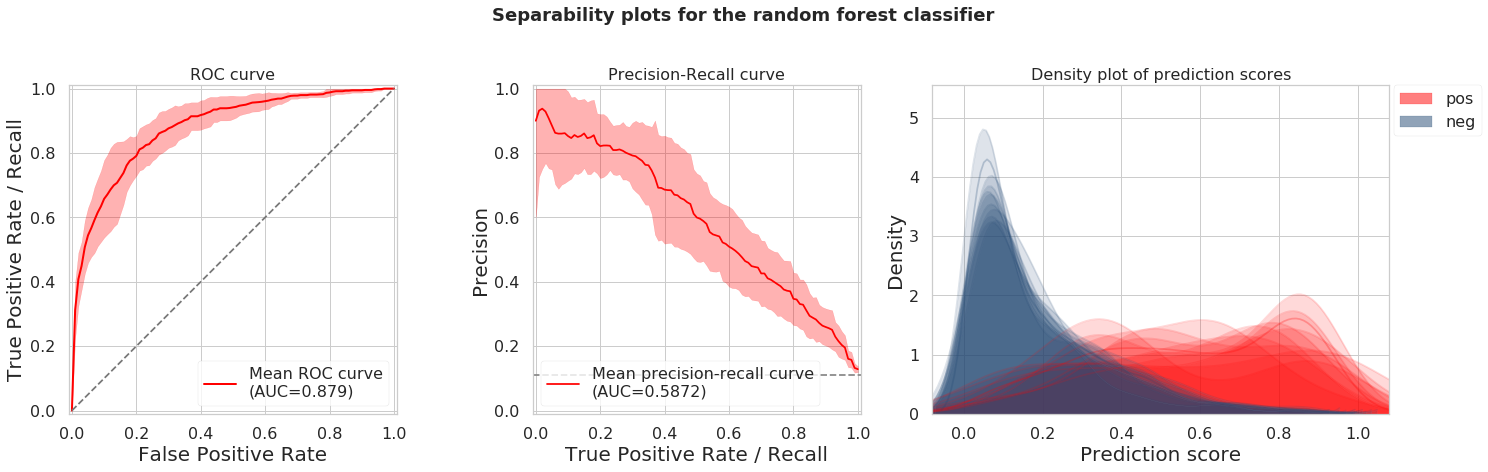

CPU times: user 620 ms, sys: 4 ms, total: 624 ms
Wall time: 678 ms


In [27]:
%%time

# FIGURE ON SEPARABILITY
ML_visualization.separability_plots(
                    r,
                    mean_only=True,
                    class_names = ['neg','pos'],
                    color_positives='#ff0000',
                    color_negatives='#224873',
                    color_surface='#ff0000',
                    main_title='Separability plots for the random forest classifier',
                    savefig_file=None
)

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


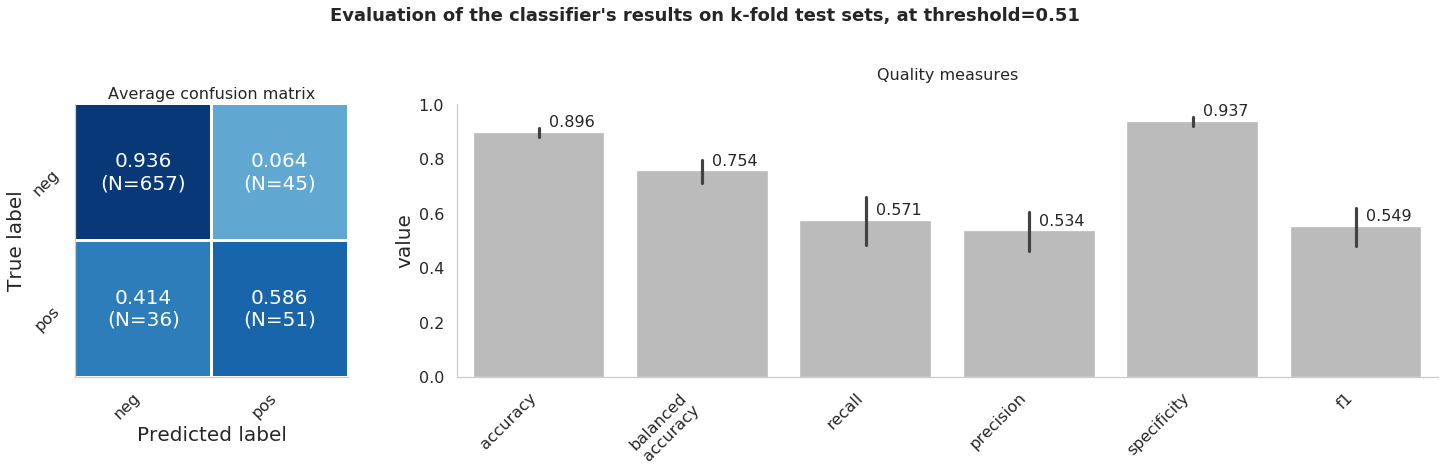

In [28]:
# FIGURE ON QUALITY OF PREDICTIONS
threshold = create_model_lib.find_best_threshold(
                [v[0] for v in r],
                [v[1] for v in r],
                scorer=sklearn.metrics.f1_score
                )

ML_visualization.quality_classification_plots(
                             [kf_res[0] for kf_res in r],
                             [(kf_res[1][:,1]>threshold).astype(int) for kf_res in r],
                             normalize=True,
                             class_names=['neg','pos'],
                             main_title="Evaluation of the classifier's results on k-fold test sets, at threshold={:.3}".format(threshold),
)

## Stratified K-fold

In [29]:
r = kfolds_results['Stratified10Folds_woTargs_testImb12.5']['res_list']

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


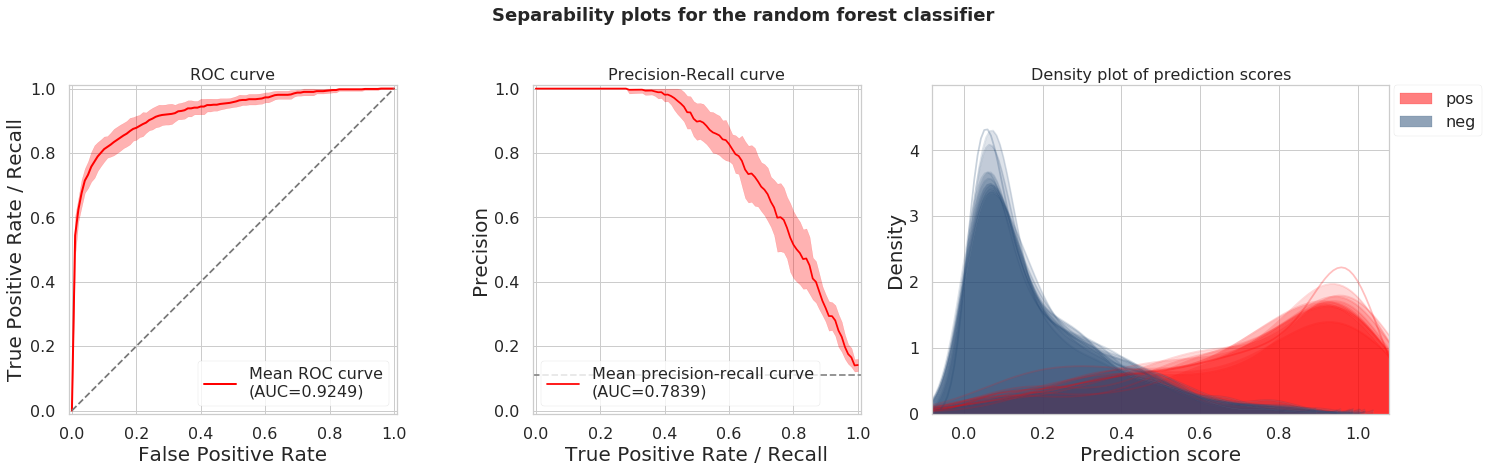

CPU times: user 588 ms, sys: 0 ns, total: 588 ms
Wall time: 590 ms


In [30]:
%%time

# FIGURE ON SEPARABILITY
ML_visualization.separability_plots(
                    r,
                    mean_only=True,
                    class_names = ['neg','pos'],
                    color_positives='#ff0000',
                    color_negatives='#224873',
                    color_surface='#ff0000',
                    main_title='Separability plots for the random forest classifier',
                    savefig_file=None
)

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


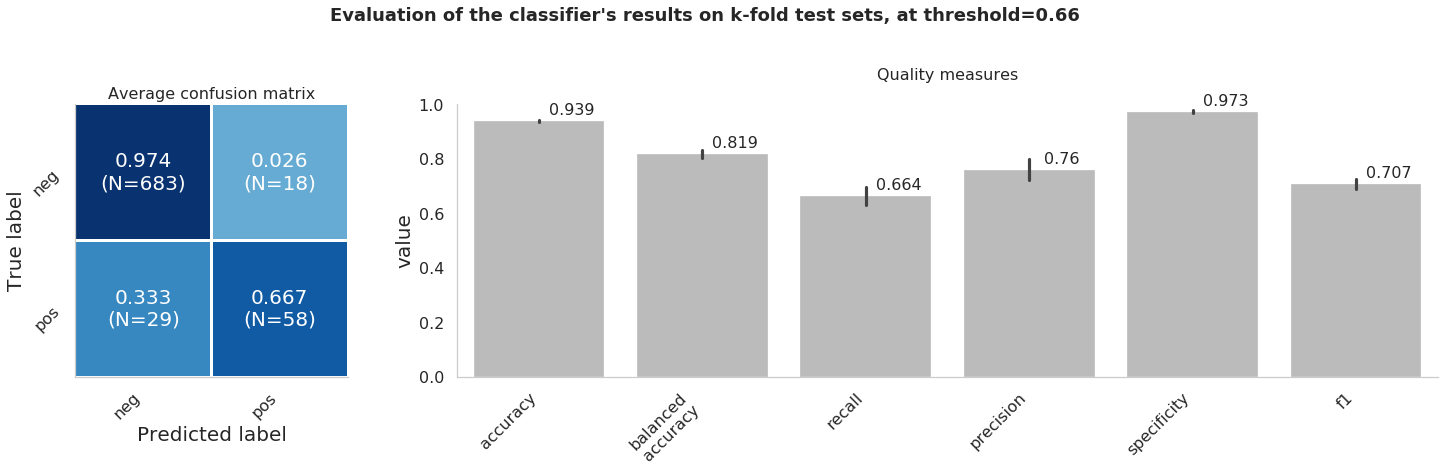

In [31]:
# FIGURE ON QUALITY OF PREDICTIONS
threshold = create_model_lib.find_best_threshold(
                [v[0] for v in r],
                [v[1] for v in r],
                scorer=sklearn.metrics.f1_score
                )

ML_visualization.quality_classification_plots(
                             [kf_res[0] for kf_res in r],
                             [(kf_res[1][:,1]>threshold).astype(int) for kf_res in r],
                             normalize=True,
                             class_names=['neg','pos'],
                             main_title="Evaluation of the classifier's results on k-fold test sets, at threshold={:.3}".format(threshold),
)

# Full model exploration

Here we want to highlight how the random sampling of variants happened during the training of the FINSURF-Adjusted random forest.

The random forest implementation being a *balanced* random forest, each tree samples (with replacement) a total of N variants per class, N being defined from the smallest set of variants (in our case: class 1, or positive controls).

Such sampling thus leads to a number of unique variants $ N^{class}_{tree\_idx, class} < N^{class}_{total} $ per tree.

For each tree in the random forest, the set of sampled variants per class will vary, allowing different combinations of positive and negative controls.

- for the positive control class, the average number of uniquely sampled variants per tree is 2/3 of the total number (in our case, about 585 variants, over the 878).

- for the negative control class, the balanced implementation requires to sample N=878 variants from a very large set. Thus, despite the sampling with replacement, the vast majority of sampled negative controls are unique in a given tree.


This means that when iterating of the trees in the forest, the cumulative number of uniquely sampled variants will raise more slowly for the negative controls than for the positive controls.

This also means that for a large enough negative control dataset, it is possible that the total number of uniquely sampled negative controls does not reach the total of variants available:

$ \sum^{T}_{tree\_idx} (N^{class}_{tree\_idx}) < N^{class}_{total}$

As the boundary for the total of uniquely sampled variants is $ T * (N^{smallest\ class}) $  = 1,000 * 878 = 878,000 variants

Below we illustrate these points by showing the cumulative number of uniquely sampled variants for each class across the 1,000 trees of the FINSURF adjusted model.

We make use of a function that allows to retrieve the indices of sampled variants in a given tree that has been trained.

This function also allows to identify which are the variants that were **not** sampled in a tree.
This leads to the identification of **out-of-bags samples**, which are the sets of variants that were not sampled in each trees.

These are internally used to calculate the out-of-bag error (1-accuracy).
We show below how to access these manually, and how to calculate other metrics from these.

Besides, this function was used internally in the script dedicated to computing the feature contributions.
We highlight this again in the subsection where we re-calculate the feature contributions.

## Total number of uniquely variant sampled

Here we want to illustrate how does the balanced random sampling with replacement happening in each tree leads work.

The plot in this section below indicates how many unique variants are considered by the forest while iterating over the trees.

The number of positives (N=878) is not covered entirely in the first tree, as the sampling will replacement will lead to about ~2/3 of these variants to be uniquely sampled.
But we see that after a few trees the number of unique variants "seen" saturates, meaning that considering these few trees allowed to sample at least once each of the variant in the dataset.

This saturation happens at a higher number of trees when looking at the negative set (N_trees > 200).

In [32]:
def accumulate_balanced_sampling_unique_indices():
    """Get from each tree the sample and un-sampled indices of variants randomly sampled during training.
    """
    # Extract the balanced random forest.
    finsurf_rf = finsurf_model.named_steps['balanced_rdf']
    
    sampled_indices = []
    unsampled_indices = []
    # Here: iterate over the trees, accumulating indices of variants (and their associated class) in a list.
    for i, tree in enumerate(finsurf_rf.estimators_):
        if i%100==0: print(i)
            
        tmp = finsurf_forest._generate_sample_indices(tree.random_state, y)
        sampled = pd.Series(y, name='class_variant')[tmp].to_frame().reset_index()
        sampled_indices.append(sampled)
        
        tmp = finsurf_forest._generate_unsampled_indices(tree.random_state, y)
        unsampled = pd.Series(y, name='class_variant')[tmp].to_frame().reset_index()
        unsampled_indices.append(unsampled)
        
    return (sampled_indices, unsampled_indices)


(sampled_indices, unsampled_indices) = accumulate_balanced_sampling_unique_indices()

0
100
200
300
400
500
600
700
800
900


In [33]:
def unique_ID_sample_accumulation(sampled_indices):
    """Count the cumulative number of unique IDs sampled.
    
    Each element of the list corresponds to the table of sampled indices of variants.
    The unique set of sampled indices is obtained for each class, and then compared to the set accumulated so far.
    
    
    Args:
        sampled_indices (list[pd.DataFrame]): list of sampled indices tables where each table contains
                                                columns 'class_variant' and 'index'
    Returns:
        pd.DataFrame: with three columns: 'tree_idx', 'class_variant', 'N_cumulated'
    """
    
    uniq_indices_per_class = {0:[], 1:[]}
    cumulative_set = {0:[],1:[]}
    N_uniq_sampled_cumulative = [] # This will be a long list which will be transformed to a table.
    
    for i, sampled in enumerate(sampled_indices):
        if i%200==0: print(i)
        for class_variant in (0,1):
            tmp_class = sampled.loc[lambda df: df['class_variant']==class_variant,'index'].unique()
            uniq_indices_per_class[class_variant].append(list(tmp_class))
            
            # Now get the number of unique sampled indices, cumulated across trees seen so far.
            if i>0:
                previous_cumulative_set = cumulative_set[class_variant][i-1]
            else:
                previous_cumulative_set = set()
            
            cumulated = set(tmp_class) | previous_cumulative_set
            cumulative_set[class_variant].append(cumulated)
            
            N_cumulated = len(cumulated)
            
            N_uniq_sampled_cumulative.append(pd.Series([i, class_variant, N_cumulated],
                                                       index=['tree_idx','class_variant','N_uniq_cumulated']))
    
    N_uniq_sampled_cumulative = pd.DataFrame(N_uniq_sampled_cumulative)
    return N_uniq_sampled_cumulative


unique_ID_sample_accumulation = unique_ID_sample_accumulation(sampled_indices)

0
200
400
600
800


/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


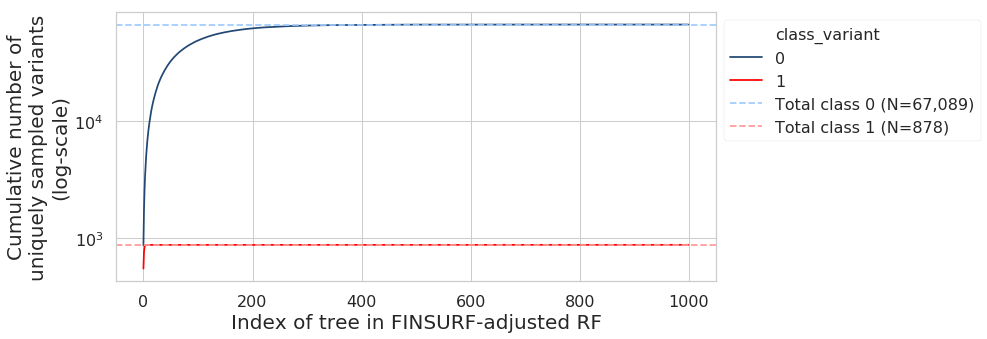

In [34]:
def plot_unique_ID_sample_accumulation(unique_ID_sample_accumulation, y):
    
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(1,1,1)
    
    palette = {0:'#224873',1:'#FF0000'}
    
    sns.lineplot(
        data=unique_ID_sample_accumulation,
        x='tree_idx',
        y='N_uniq_cumulated',
        hue='class_variant',
        palette=palette,
        ax=ax1)
    
    ax1.axhline((y==0).sum(),label=f'Total class 0 (N={(y==0).sum():,})',
                linestyle='--',color='#A0CBFF')
    ax1.axhline((y==1).sum(),label=f'Total class 1 (N={(y==1).sum():,})',
                linestyle='--',
                color='#FF9B9B')
    
    ax1.set_yscale('log')
    
    ax1.set_xlabel('Index of tree in FINSURF-adjusted RF')
    ax1.set_ylabel('Cumulative number of\nuniquely sampled variants\n(log-scale)')
    
    ax1.legend(bbox_to_anchor=(1,1))
    ax1.legend_.set_title('')
    
    return ax1


ax = plot_unique_ID_sample_accumulation(unique_ID_sample_accumulation, y)
plt.show()

## Out-of-bag metrics

The Out-of-bag approach of evaluating random forests allows the evaluation of performance of a complete model from the unsampled variants.

This can be used in place of the cross-validation approach, although you do not get any variation in the sampled variants, and you lose control over the splits of train/validation sets.
Nonetheless this is an interesting approach for evaluating your complete model.

For each tree, variants that were left out are identified, and their class is predicted by the considered tree.

A sparse matrix is thus assembled, where each variant gets a prediction score from the subset of trees where it was not sampled.

From these, one can calculate performance metrics which will represent performance of the model on a validation-like dataset, a better estimate of the real performance of the model than applying it on the entire training dataset.

This approach will nonetheless overestimate performance, as we showed with the different cross-validation approaches: variants can share similar genomic locations, and thus a given out-of-bag variant will benefit from the annotations of all other variants within a local genomic range.

This is why our cross-validation approach with splits based on cytogenetic-band is a better way of validating the model.

## Feature contributions

We calculate here the feature contributions of all variants that have been used for the training of the model.

The *Out-of-bag* samples can be used to have an overview of how the annotations of "independent variants" are exploited by the subset of trees where these variants were not sampled.

The `Interpreter` class makes use internally of the function that allows to identify these out-of-bag samples, as used in the out-of-bag metrics computations.

To enable this, the option `train_dataset` is set to `True`, indicating that feature contributions of a given variant should be calculated only from the trees that did not sample this variant for its training.

In [35]:
interpreter = finsurf_treeinterpreter_nopool.Interpreter(
                model=finsurf_model,
                 X=X.loc[:,model_columns],
                 y=y,
                 train_dataset=True,
                )

CAUTION: make sure you are indeed inputing the train dataset.


In [36]:
%%time
interpreter.predict()

Feature contrib - tree 50
Feature contrib - tree 100
Feature contrib - tree 150
Feature contrib - tree 200
Feature contrib - tree 250
Feature contrib - tree 300
Feature contrib - tree 350
Feature contrib - tree 400
Feature contrib - tree 450
Feature contrib - tree 500
Feature contrib - tree 550
Feature contrib - tree 600
Feature contrib - tree 650
Feature contrib - tree 700
Feature contrib - tree 750
Feature contrib - tree 800
Feature contrib - tree 850
Feature contrib - tree 900
Feature contrib - tree 950
	Done.
Generating unsampled indices per tree..
	Generate sampled indices
	Tree 50 - get sampled idx
	Tree 100 - get sampled idx
	Tree 150 - get sampled idx
	Tree 200 - get sampled idx
	Tree 250 - get sampled idx
	Tree 300 - get sampled idx
	Tree 350 - get sampled idx
	Tree 400 - get sampled idx
	Tree 450 - get sampled idx
	Tree 500 - get sampled idx
	Tree 550 - get sampled idx
	Tree 600 - get sampled idx
	Tree 650 - get sampled idx
	Tree 700 - get sampled idx
	Tree 750 - get sampled 

In [37]:
%%time

# HERE : Build the feature contributions dataframe,
# which associate to each variant K rows (K being the number of classes)
# each row containing the feature contributions for the considered class.
# NOTE : for binary classification, one row is equal to (1 - the second row).
# So when you want to manipulate these FC, you can consider only the class of interest
# (here : 1, for functional variants)

feature_contrib_df = []
for i, (mat, idx) in enumerate(zip(interpreter.finale_FC_mat, sorted(list(interpreter._full_training_indices_set)))):
    if i%10000==0:
        print("{} - {}".format(datetime.datetime.now(), i))              
    feature_contrib_df.append(pd.DataFrame(mat.T,columns=['pred','bias']+list(model_columns)).reset_index().rename(columns={'index':'class'}).assign(sample_idx=idx))
    
feature_contrib_df = pd.concat(feature_contrib_df)

2021-11-19 13:32:40.627782 - 0
2021-11-19 13:32:53.485038 - 10000
2021-11-19 13:33:05.769266 - 20000
2021-11-19 13:33:17.861820 - 30000
2021-11-19 13:33:29.761678 - 40000
2021-11-19 13:33:41.669021 - 50000
2021-11-19 13:33:52.910695 - 60000
CPU times: user 1min 51s, sys: 1.9 s, total: 1min 53s
Wall time: 1min 48s


In [38]:
%%time
# Here our class of interest is the class 1 ; 'functional'. 
feature_contribs_cl1 = feature_contrib_df.loc[feature_contrib_df['class']==1,:
                                    ].set_index('sample_idx').drop('class',axis=1).sort_index()

CPU times: user 2.64 s, sys: 176 ms, total: 2.81 s
Wall time: 85 ms


In [39]:
feature_contribs_cl1.insert(0, 'row_id', X['row_id'].values)
feature_contribs_cl1.insert(1, 'y', y)

In [40]:
display(feature_contribs_cl1.head(3))

,row_id,y,pred,bias,vartrans.ord,CGdinit,CpGisland,phyl100w,phyl20w,phast100w,...,genhancer.bestScore,genhancer.count_targs,genhancer.bestScore_targs,focs_fantom.maxScore,focs_fantom.count_targs,focs_groseq.maxScore,focs_groseq.count_targs,focs_roadmap.maxScore,focs_roadmap.count_targs,ratio_shared_targets
sample_idx,,,,,,,,,,,,,,,,,,,,,
0,chr1_308,1,0.415323,0.5,0.000191,-0.001710,0.035100,-0.050073,0.019847,-0.054377,...,-0.030680,0.024144,-0.037126,-0.000513,0.000142,0.000034,0.000000,0.000000,-0.000150,0.000240
1,chr1_367,1,0.407493,0.5,-0.006897,-0.000928,0.033139,-0.062897,-0.006640,-0.049867,...,0.005597,-0.000746,-0.034656,-0.000039,0.000019,0.000000,0.000027,-0.000078,0.000000,0.000092
2,chr1_510,1,0.602324,0.5,-0.001907,0.000867,-0.003149,0.009007,0.047046,0.101271,...,0.000561,-0.007014,-0.005528,0.000016,0.000054,0.000022,0.000070,0.000204,0.000262,0.000085


# Example variants for functional profiles

We want to illustrate here how variants can be investigated using the functional profiles.

These functional profiles combine values from the annotations of each variants, and how these values were exploited by FINSURF-adjusted.

The dedicated figure panel in the paper highlighted clusters of variants showing different combinations of feature contributions.
Besides these clusters showed different percentage of false positives.

We will also illustrate this by showing a false positive variant.

## Identify variants

We applied the following filters to identify the **True Positive** candidate variants to show:

- identify the subset of positive controls in our training data that were reported in the Genomiser training data. Gather the OMIM description and the disease gene from there.

- intersect the variants with the FINSURF regulatory regions, and keep those variants in regulatory regions that target the reported disease gene.

- score the variants with the FINSURF-adjusted model and identify the high-scoring ones.

- confirm the identity of the disease variant of interest from the public database from HGMD.

For the negative control identified as a **False Positive**, we identified ClinVar negative control falling within regulatory regions predicted to target the disease gene linked to the positive control.
This is similar to what is presented in the paper (figure 4) except that here we use the ClinVar negative controls from the training dataset.

- Selected gene: SERPINC1
- variant HGMD chr1_10862
- POS=173886568, G>C ; Promoter
- Available as a 'regulatory variant' in the public database. 
- score = 0.986872
- OMIM ID: MIM 613118, Antithrombin deficiency

In [41]:
vcf_pos = pd.read_csv("../data/example_functional_profiles/TruePositive_SERPINC1.vcf",
                      header=0,
                      index_col=None,
                      sep='\t')

vcf_neg = pd.read_csv("../data/example_functional_profiles/FalsePositive_SERPINC1.vcf",
                      header=0,
                      index_col=None,
                      sep='\t')

numeric_examples = pd.read_csv("../data/example_functional_profiles/numeric_annotations_SEPINC1.tsv",
                               header=0,
                               index_col=None,
                               sep="\t"
                              )


scaled_numeric_examples = pd.read_csv("../data/example_functional_profiles/scaled_numeric_annotations_SEPINC1.tsv",
                                      header=0,
                                      index_col=None,
                                      sep="\t"
                                     )


featcontrib_examples = pd.read_csv("../data/example_functional_profiles/feature_contributions_SEPINC1.tsv",
                                      header=0,
                                      index_col=None,
                                      sep="\t"
                                     )

# Feature contributions are read from the exported table, but can also be accessed:
# - using the model.
# - using the feature contribution tables that are available for download
#   when accessing the repository dedicated to "FINSURF offline".


# Here: demo with the feature contribution table calculated previously.
# pos_feat_cont = feature_contribs_cl1.loc[lambda df: df['row_id']==vcf_pos['row_id'].iloc[0],
#                                          model_columns].reset_index(drop=True).iloc[0]




In [42]:
# Here: confirm that the scores of the two variants (first: true positive, second: false positive)
examples_serpinc1_scores = finsurf_model.predict_proba(numeric_examples.loc[:,model_columns])[:,1]
examples_serpinc1_scores = pd.Series(examples_serpinc1_scores, index=['pos','neg'])
print(examples_serpinc1_scores)

pos    0.986872
neg    0.514110
dtype: float64


## Definitions

In [43]:
def plot_functional_profile(scaled_features,
                            color_feat_map,
                            map_rename={},
                            title="",
                            savefig_file=None):
    """
    """
    fig = plt.figure(figsize=(18, 7))
    ax1 = fig.add_subplot(1,1,1)

    sns.barplot(data=scaled_features.rename('feature').reset_index(),
                x='index',
                y='feature',
                ax=ax1
                )
    for feature_tick, patch_feature in zip(ax1.get_xticklabels(), ax1.patches):
        patch_feature.set_facecolor(color_feat_map[feature_tick.get_text()])
        patch_feature.set_edgecolor("#888888")
        patch_feature.set_linewidth(1.2)
        
    ax1.set_xticklabels([map_rename.get(v.get_text(), v.get_text()) for v in ax1.get_xticklabels()],
                        rotation=45, ha="right")

    ax1.set_ylim(-1.1, 1.1)
    ax1.set_xlabel("")
    ax1.set_ylabel("Scaled feature")

    # Here we add the colorbar.
    sm = plt.cm.ScalarMappable(cmap=cmap)
    # NOTE: these values are defined from manual
    # inspection of the FC distribution and mapping of colors to a [-1;1] range
    # using the HGMD-DM + Cytomatch controls
    sm.set_array([-0.06,0.06]) 
    colorbar = plt.colorbar(mappable=sm, ax=ax1)
    
    # Make ticks more explicit by indicating that large values are assigned to the boundaries colors.
    ticks = colorbar.get_ticks()
    ticklabels = []
    ticklabels.append("≤"+str(ticks[0]))
    ticklabels+= ["{:.3}".format(v) for v in ticks[1:-1]]
    ticklabels.append("≥"+str(ticks[-1]))

    # add the color bar to the plot.
    colorbar.ax.set_yticklabels(ticklabels)
    colorbar.set_label("Feature contribution", rotation=-90, labelpad=20)
    colorbar.ax.tick_params(color='#FFFFFF', pad=0)

    ax1.set_title(title)
    
    plt.tight_layout()
    
    if savefig_file:
        plt.savefig(savefig_file)

    plt.show()

## Prepare data

In [44]:
coloring_path = "../data/example_functional_profiles/STRUCT_FC_COLORING.pkl"
with open(coloring_path, "rb") as in_dict_FC:
    dict_FC_colors = pickle.load(in_dict_FC)
    
cmap = dict_FC_colors['cmap']
normalizer = dict_FC_colors['normalizer']

In [45]:
table_rename_cols_path = "../data/example_functional_profiles/rename_columns_model.tsv"

renaming_table = pd.read_table(table_rename_cols_path,
                               header=0,
                               index_col=None,
                               sep="\t"
                              )                 
map_rename = renaming_table.set_index("old")["new"].to_dict()

In [46]:
# This function is the one that can be used to retrieve the scaled numeric annotations
# for the barplots, from the dataset "SCALED_NUM_FEATURES.tsv.gz" which is available for download
# when one wants to use FINSURF locally.

def get_scaled_annotations(variant_query: str ,
                           scaled_features_path: str,
                           feature_list: list,
                           strip_pos_info: bool = True):
    """Query the tabix-indexed table of scaled numeric features.
    """
    bed_tabix = tabix.open(scaled_features_path)
    query_res = bed_tabix.querys(variant_query)
    res = list(query_res)
    if not len(res)==1:

        #raise RuntimeError("More than 1 hit.")
    
        return res
    
    if strip_pos_info:
        scaled_features = pd.Series(res[0][4:],
                                    name='scaledNum',
                                    index=feature_list
                                    ).astype(float)
    else:
        scaled_features = pd.Series(res[0],
                                    name='scaledNum',
                                    index=['chrom','start','end','id']+feature_list
                                    )

    return scaled_features

# The query is composed of the 1-based position of the variant (you can take the POS from the VCF)
# such as "<chrom>:<POS>-<POS>"

# pos_query = f"{vcf_pos['#chrom'].iloc[0]}:{vcf_pos['pos'].iloc[0]}-{vcf_pos['pos'].iloc[0]}"

# scaled_features_path = "/PATH/TO/SCALED_NUM_FEATURES.tsv.gz"
    
# pos_scaled_features = get_scaled_annotations(
#                            pos_query,
#                            scaled_features_path=scaled_features_path,
#                            feature_list=model_columns,
#                            strip_pos_info=True)

### Functional profile: true positive

In [47]:
pos_scaled_features = scaled_numeric_examples.iloc[0,:]
pos_feat_cont = featcontrib_examples.iloc[0,:]

# This will be used to color the scaled features barplot with feature contributions.
pos_color_feat_map = pd.Series([mpl.colors.rgb2hex(v) for v in cmap(normalizer(pos_feat_cont.values))],
                               index=model_columns
                              ).to_dict()

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


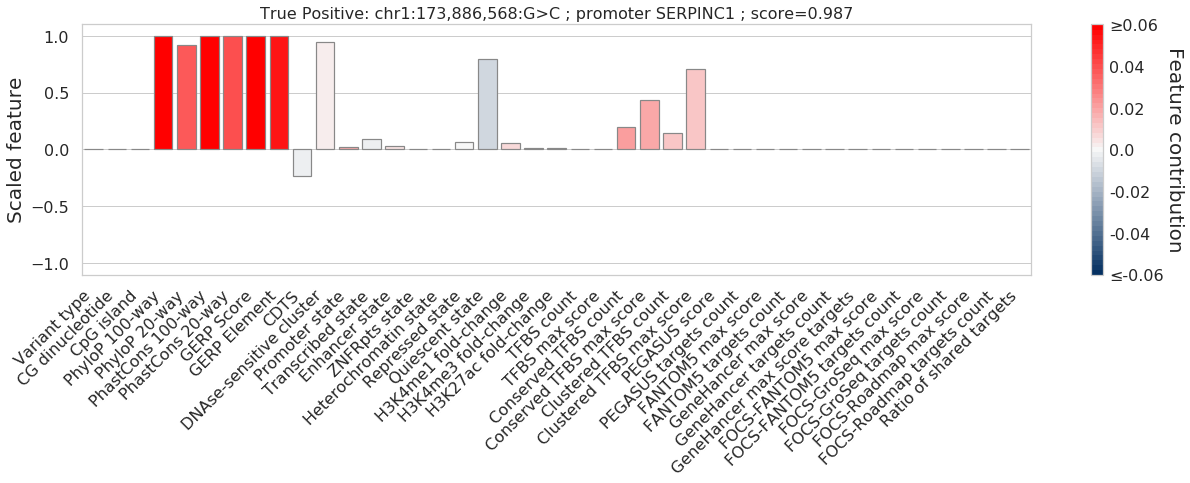

In [48]:
var_identifier = (f"{vcf_pos['#chrom'].iloc[0]}:{vcf_pos['pos'].iloc[0]:,}:"
                  f"{vcf_pos['ref'].iloc[0]}>{vcf_pos['alt'].iloc[0]} ; promoter SERPINC1"
                  f" ; score={examples_serpinc1_scores['pos']:.3}")

plot_functional_profile(pos_scaled_features, 
                        pos_color_feat_map,
                        map_rename,
                        title="True Positive: "+var_identifier,
                        savefig_file=None)

### Functional profile: false positive

In [49]:
neg_scaled_features = scaled_numeric_examples.iloc[1,:]
neg_feat_cont = featcontrib_examples.iloc[1,:]

neg_color_feat_map = pd.Series([mpl.colors.rgb2hex(v)
                                for v in cmap(normalizer(neg_feat_cont.values))],
                               index=model_columns
                              ).to_dict()

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


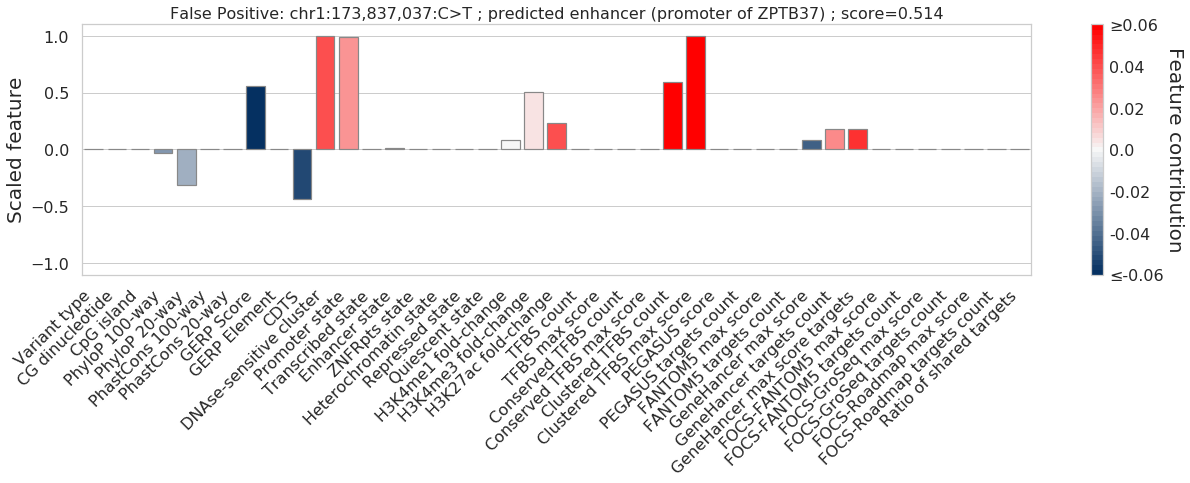

In [50]:
var_identifier = (f"{vcf_neg['#chrom'].iloc[0]}:{vcf_neg['pos'].iloc[0]:,}:"
                  f"{vcf_neg['ref'].iloc[0]}>{vcf_neg['alt'].iloc[0]} ; predicted enhancer (promoter of ZPTB37)"
                  f" ; score={examples_serpinc1_scores['neg']:.3}")


plot_functional_profile(neg_scaled_features,
                        neg_color_feat_map,
                        map_rename,
                        title="False Positive: "+var_identifier,
                        savefig_file=None)